In [1]:
%matplotlib notebook

from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 10.0)

from matplotlib.patches import Circle
from matplotlib.cm import colors
from matplotlib import cm
from sklearn.linear_model import LogisticRegression
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

## Data Generation

Let's generate some fake data that cannot be separated by a linear separator. In fact, all we are doing is setting $y = (1 + \mathrm{sign}(x_1  x_2 + \eta))/2$, where $\eta$ is some noise. So $y \in \{0, 1\}$ and we get a classification problem. $x_1, x_2$ are drawn from the standard normal distribution.

In [2]:
N, D = 1000, 2
X = np.random.randn(N, D)
Y = (np.sign(X[:, 0] * X[:, 1] + np.random.randn(N) * 0.1) + 1)/2

## Visualising the Data

Let's plot the data with red being $0$ and blue being $1$.

In [3]:
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0., 0.)],
     'green': [(0, 0, 0.), (1, 0., 0.)],
     'blue': [(0, 0., 0.), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

<IPython.core.display.Javascript object>


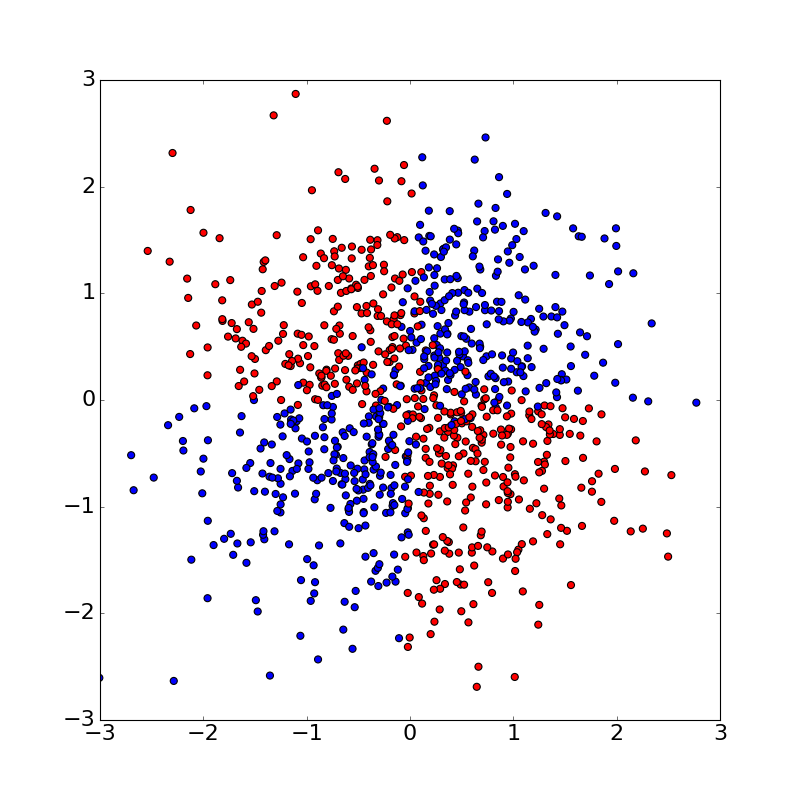

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.tick_params(axis='both', labelsize=20)

ax.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap='red_blue_classes')

## Logistic Regression

Clearly this data is not linearly separable, but let us see how badly logistic regression does

In [5]:
lr = LogisticRegression()
lr.fit(X, Y)
yhat = lr.predict(X)
# Line: lr.coef_[0] * x1 + lr.coef_[1] * x2 + lr.intercept_ = 0
# xmin, xmax = -3, 3
# y = -(lr.coef_[1])^{-1} * (lr.intercept_ + lr.coef_[0] * x1)
xmin, xmax = -3, 3
ymin = -(1/lr.coef_[0, 1]) * (lr.coef_[0, 0] * xmin + lr.intercept_)
ymax = -(1/lr.coef_[0, 1]) * (lr.coef_[0, 0] * xmax + lr.intercept_)

<IPython.core.display.Javascript object>


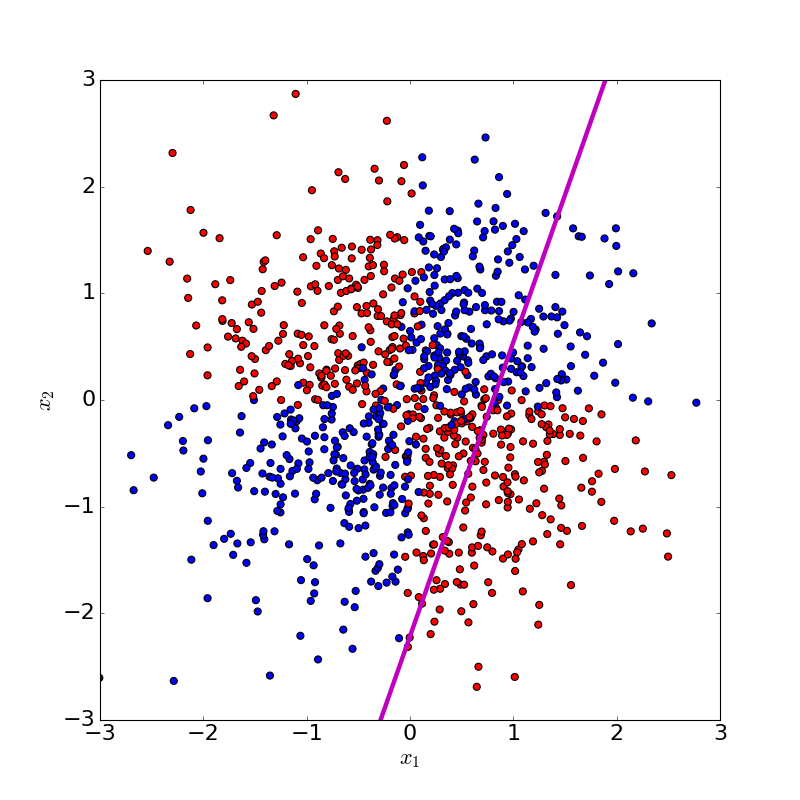

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.tick_params(axis='both', labelsize=20)
ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)

ax.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap='red_blue_classes')
ax.plot([xmin, xmax], [ymin, ymax], lw='4', c='m')

## Neural Nets

Let us now use a simple neural network with one hidden layer, 2 hidden units in the hidden layer and sigmoid non-linearities everywhere. 

In [7]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.4)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [8]:
x = tf.placeholder(tf.float32, shape=[None, 2])
y_ = tf.placeholder(tf.float32, shape=[None, 1]) 

W_1 = weight_variable([2, 2])
b_1 = bias_variable([2])
h_1 = tf.nn.tanh(tf.matmul(x, W_1) + b_1)

W_2 = weight_variable([2, 1])
b_2 = bias_variable([1])
y = tf.matmul(h_1, W_2) + b_2

In [9]:
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(y, y_))
train_step_gd = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [10]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
errs = np.zeros(2000)
for i in range(2000):
    sess.run(train_step_gd, feed_dict={x: X, y_: Y.reshape(1000, 1)})
    errs[i] = sess.run(cross_entropy, feed_dict={x: X, y_: Y.reshape(1000, 1)})

<IPython.core.display.Javascript object>


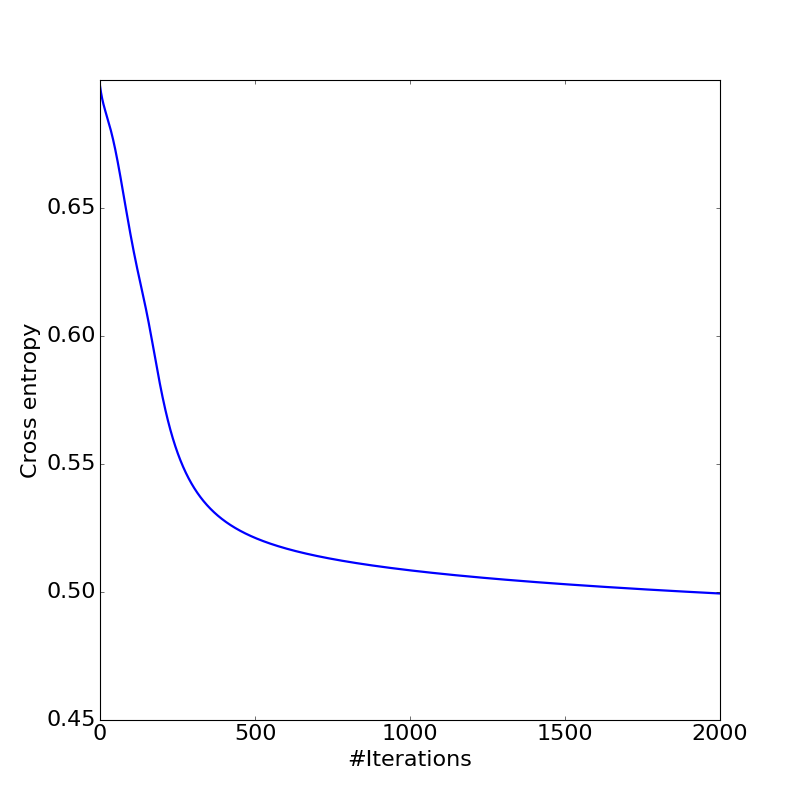

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both', labelsize=20)
ax.set_xlabel('#Iterations', fontsize=20)
ax.set_ylabel('Cross entropy', fontsize=20)
ax.plot(errs, lw=2)

In [12]:
# Let's compute the classification error
yhattf = sess.run(y, feed_dict={x: X})
print 'Classification (Train) Error: %f' % np.mean((np.sign(yhattf.squeeze())+ 1)/2 == Y)

Classification (Train) Error: 0.679000


In [13]:
# Let's store the activations of the input functions
a2 = np.zeros([N, D])
a2 = sess.run(h_1, feed_dict={x: X}).squeeze()

<IPython.core.display.Javascript object>


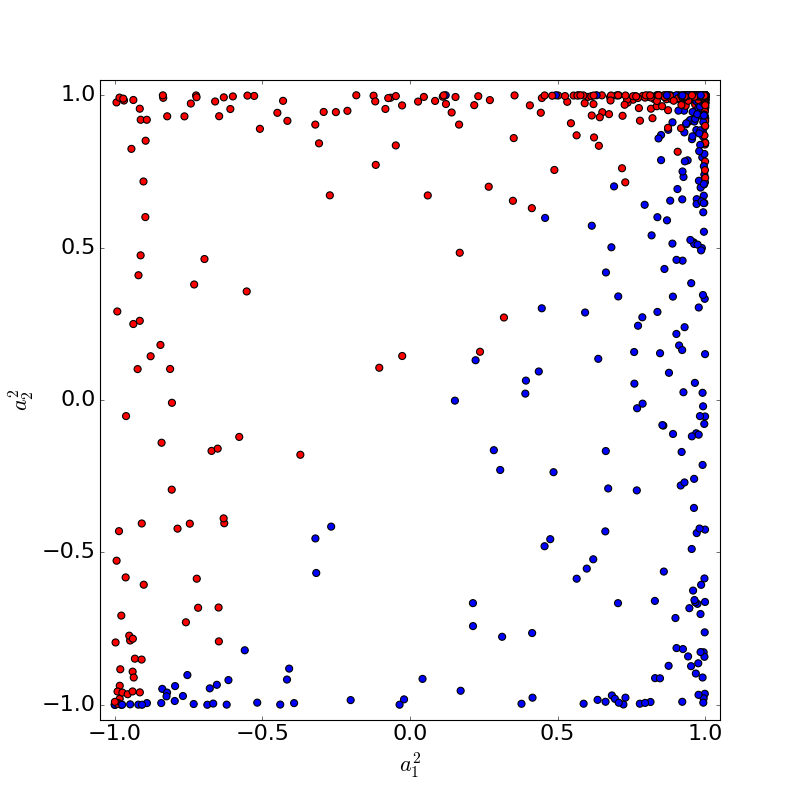

In [14]:
# Plot what the activations of the intermediate layer look like
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(-1.05, 1.05)
ax.tick_params(axis='both', labelsize=20)
ax.set_xlabel('$a^2_1$', fontsize=20)
ax.set_ylabel('$a^2_2$', fontsize=20)
ax.scatter(a2[:, 0], a2[:, 1], c=Y, s=40, cmap='red_blue_classes')

Finally, let us plot what the decision boundary looks like in the case of the neural network. We see that it is very clearly non-linear. Though the exact shape and error rate you get will depend on the random run.

<IPython.core.display.Javascript object>


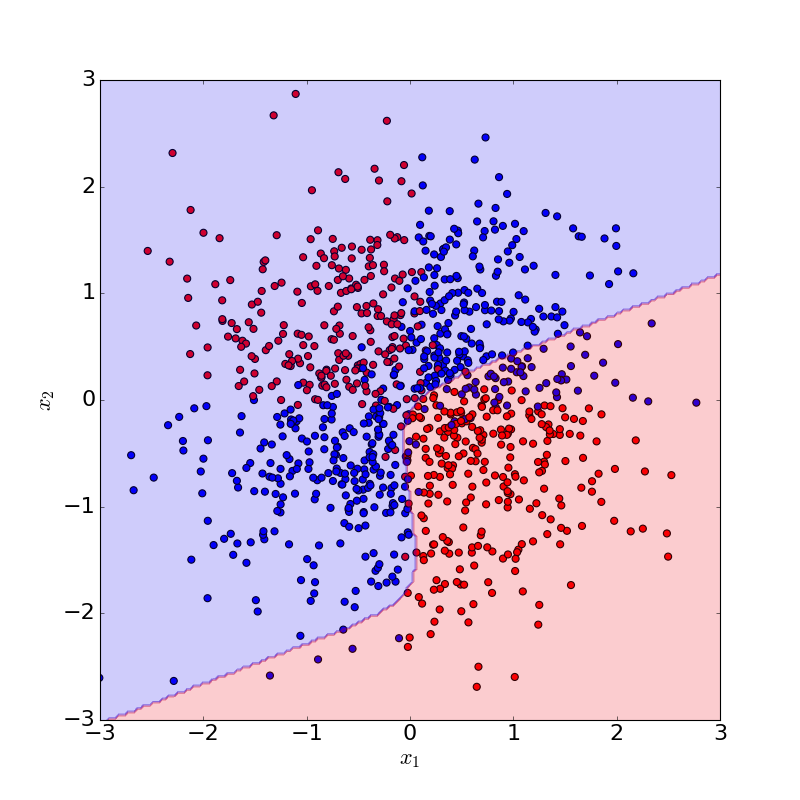

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.tick_params(axis='both', labelsize=20)
ax.set_xlabel('$x_1$', fontsize=20)
ax.set_ylabel('$x_2$', fontsize=20)
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
Z = sess.run(y, feed_dict={x: np.c_[xx.ravel(), yy.ravel()]}).squeeze()
Z = (np.sign(Z) + 1)/2
Z = Z.reshape(xx.shape)

ax.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap='red_blue_classes')
#ax.plot([xmin, xmax], [ymin, ymax], lw='4', c='m')
ax.contourf(xx, yy, Z, cmap='red_blue_classes', alpha=0.2)